In [1]:
# 모듈 임포트하기
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(f"Using Pytorch version : {torch.__version__}, Device : {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 10

Using Pytorch version : 1.8.1, Device : cpu


In [3]:
# CIFAR-10 데이터 다운로드 하기 (Train, Test set 분리)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR-10",
                                      train = True,
                                      download= True,
                                      transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(), # 해당 이미지를 50% 확률로 좌우 반전
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              (0.5, 0.5, 0.5), # 평균
                                              (0.5, 0.5, 0.5) #표준편차
                                          )
                                      ]))
test_dataset = datasets.CIFAR10(root = "../data/CIFAR-10",
                                      train = False,
                                      transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              (0.5, 0.5, 0.5), # 평균
                                              (0.5, 0.5, 0.5) #표준편차
                                          )
                                      ]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Files already downloaded and verified


In [4]:
# 데이터 확인하기 (1)
for (X_train, y_train) in train_loader :
    print(f"X_train : {X_train.size()}, type : {X_train.type()}")
    print(f"y_train : {y_train.size()}, type : {y_train.type()}")
    break

X_train : torch.Size([32, 3, 32, 32]), type : torch.FloatTensor
y_train : torch.Size([32]), type : torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

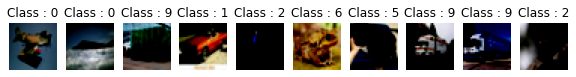

In [5]:
# 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1,2,0)))
        # pytorch 에선 [mini_batch, channel, height, width], 시각화 하기 위해서 [width, height, channel]로 변경
    plt.title(f'Class : {str(y_train[i].item())}')


In [6]:
# 파이토치 내에서 제공하는 ResNet34 모델 불러온 후 FC 층 추가 및 Output 크기 설정하기
import torchvision.models as models
model = models.resnet34(pretrained=True)
    # True로 하면 ImageNet 데이터로 미리 학습된 모델을 불러오고 아니면 특정 initializer에서 랜덤하게 샘플링 한 값을 이용하는 모델 불러옴
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/kangjaehoon/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Optimizer, Objective Function 설정하기
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval, epoch) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0 :
            print(f"Train Epoch : {epoch} [{batch_idx*len(image)}/"
                  f"{len(train_loader.dataset)}({100.*batch_idx/len(train_loader):.0f}%)]"
                  f"\tTrain Loss : {loss.item()}")

In [9]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)

            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [10]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200, epoch=Epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH:{Epoch}] \tTest Loss : {test_loss:.4f} \tTest Accuracy : {test_accuracy:.2f}\n")

Train Epoch : 1 [0/50000(0%)]	Train Loss : 2.704134702682495
Train Epoch : 1 [6400/50000(13%)]	Train Loss : 1.4499133825302124
Train Epoch : 1 [12800/50000(26%)]	Train Loss : 1.7089205980300903
Train Epoch : 1 [19200/50000(38%)]	Train Loss : 1.3178800344467163
Train Epoch : 1 [25600/50000(51%)]	Train Loss : 1.0633419752120972
Train Epoch : 1 [32000/50000(64%)]	Train Loss : 1.2705187797546387
Train Epoch : 1 [38400/50000(77%)]	Train Loss : 0.7611223459243774
Train Epoch : 1 [44800/50000(90%)]	Train Loss : 1.0987739562988281

[EPOCH:1] 	Test Loss : 0.0504 	Test Accuracy : 63.56

Train Epoch : 2 [0/50000(0%)]	Train Loss : 0.721750020980835
Train Epoch : 2 [6400/50000(13%)]	Train Loss : 1.005283236503601
Train Epoch : 2 [12800/50000(26%)]	Train Loss : 0.6714336276054382
Train Epoch : 2 [19200/50000(38%)]	Train Loss : 1.0661135911941528
Train Epoch : 2 [25600/50000(51%)]	Train Loss : 0.6002038717269897
Train Epoch : 2 [32000/50000(64%)]	Train Loss : 0.6697905659675598
Train Epoch : 2 [38400